In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

## Minimum Variance Portfolio Backtest.

In [2]:
from qamsi.config.trading_config import TradingConfig
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from run import Dataset, initialize

In [3]:
REBAL_FREQ = "ME"
DATASET = Dataset.TOPN_US
TOP_N = 100
ESTIMATION_WINDOW = 365

ESTIMATOR = CovEstimators.RF.value(shrinkage_type="linear")

In [4]:
trading_config = TradingConfig(
    total_exposure=1,
    max_exposure=None,
    min_exposure=None,
    trading_lag_days=1,
)

preprocessor, runner = initialize(
    dataset=DATASET,
    trading_config=trading_config,
    topn=TOP_N,
    rebal_freq=REBAL_FREQ,
)

Backtest on 2000-12-29 00:00:00 to 2024-07-31 00:00:00
Num Train Iterations: 283
Num OOS Daily Points: 5932


In [5]:
strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Computing Weights: 100%|██████████| 283/283 [04:04<00:00,  1.16it/s]


StrategyStatistics:
* final_nav = 10.190474
* geom_avg_total_r = 0.129866
* geom_avg_xs_r = 0.110569
* std_xs_r = 0.133464
* min_xs_r = -0.097256
* max_xs_r = 0.083106
* skew = -0.228651
* kurtosis = 20.263189
* max_dd = -0.259423
* sharpe = 0.828457
* alpha_buy_hold = 0.039981
* tracking_error_buy_hold = 0.154204
* ir_buy_hold = 0.259275
* factor_loadings = {'low_risk': 0.5507010869788656, 'momentum': -0.06433162032657652, 'quality': 0.12056816776935772, 'size': 0.12056978768571512, 'value': -0.22326147135348645, 'spx': 0.6584860288953798}
* alpha_benchmark = 0.044561
* alpha_benchmark_pvalue = 0.020373
* tracking_error_benchmark = 0.081601
* ir_benchmark = 0.546079
* ttest_pval = 0.353984
* levene_pval = 0.000000
* timing_ability_coef = -0.039014
* timing_ability_pval = 0.010412

In [6]:
result.std_xs_r, result.sharpe

(0.13346423458569937, 0.8284573593226658)

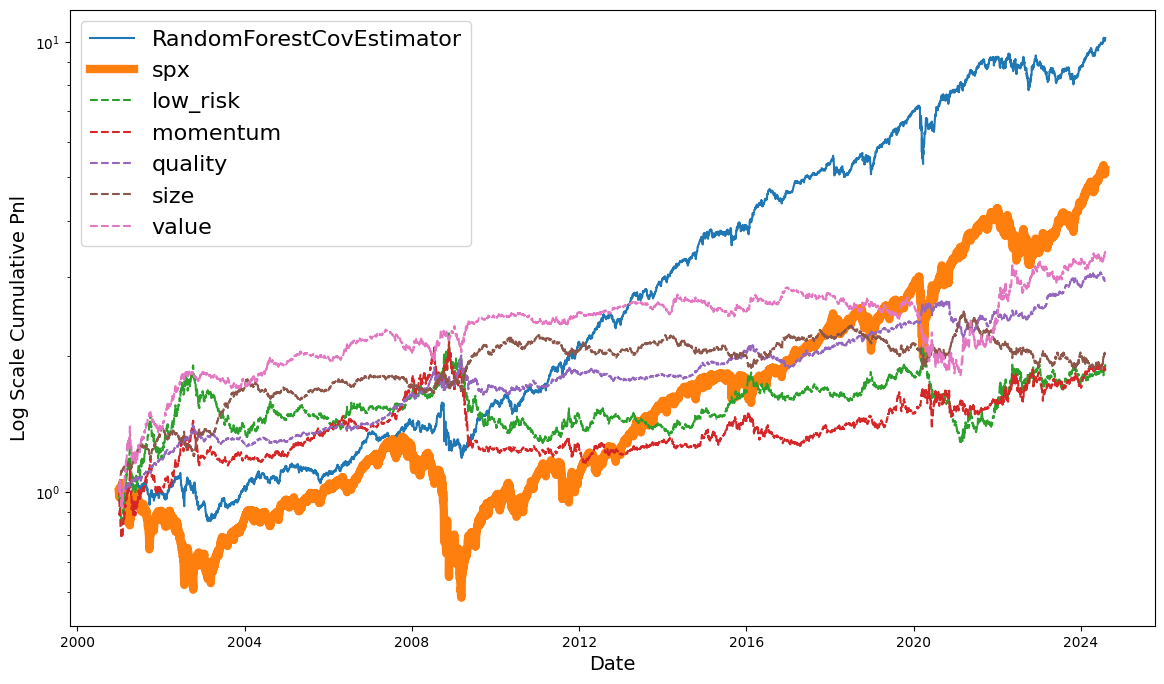

In [7]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

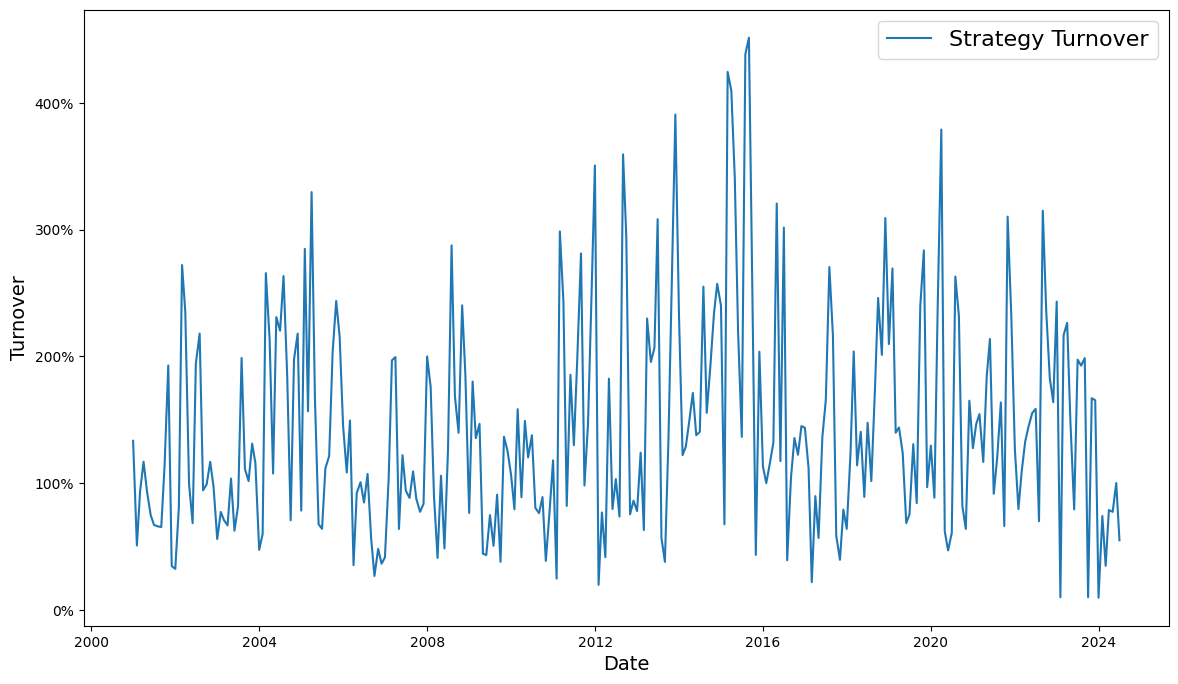

In [8]:
runner.plot_turnover()

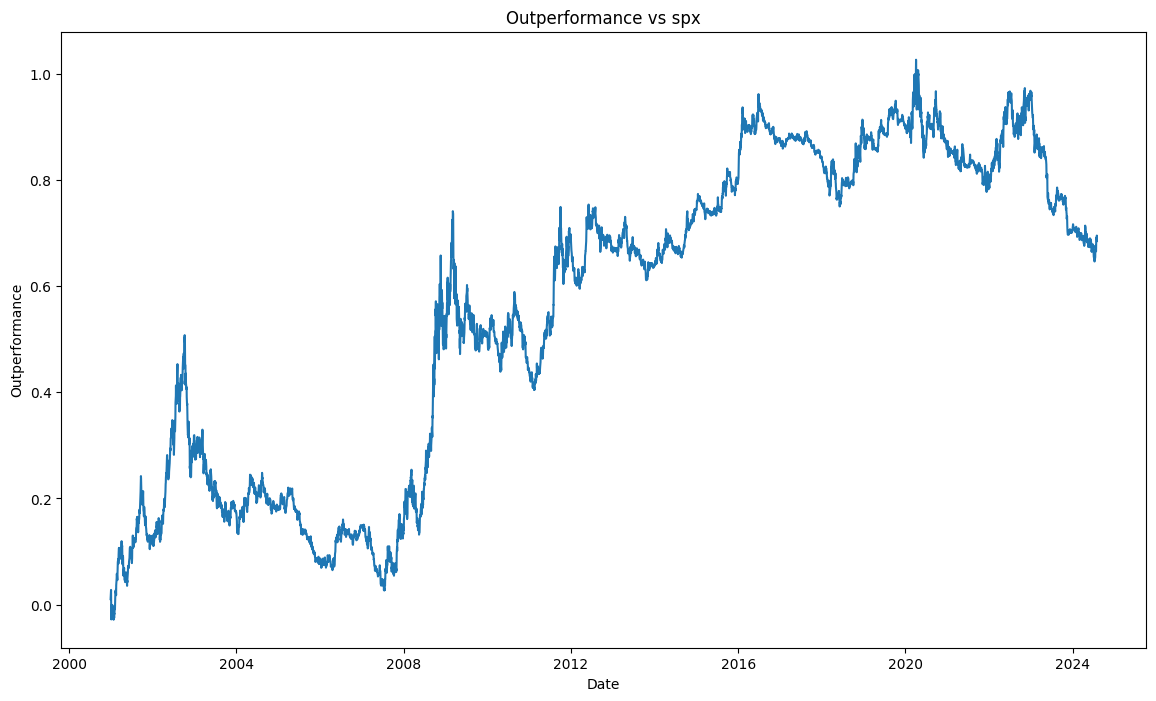

In [9]:
runner.plot_outperformance(mkt_only=True)

In [10]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")

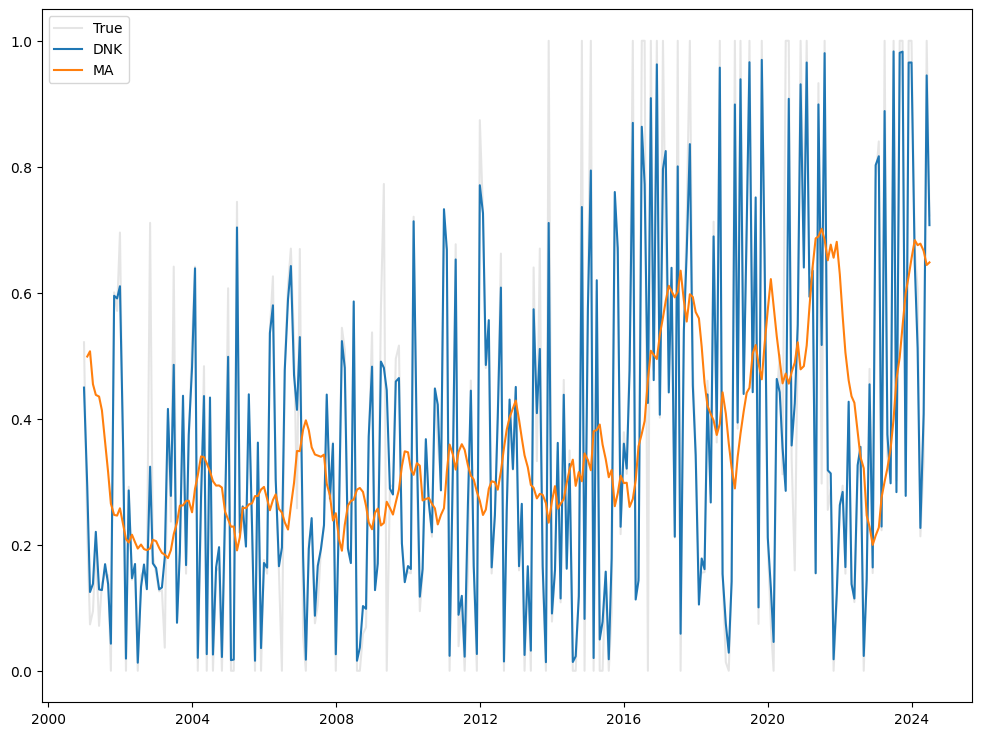

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

pred = ESTIMATOR.predictions

targets = runner.targets.loc[pred.index, "target"]
ma = runner.features.loc[pred.index, "target_rolling_mean"].shift(1)

plt.plot(
    targets.index,
    targets.to_numpy(),
    label="True",
    color="grey",
    alpha=0.2,
)
plt.plot(pred.index, pred.to_numpy(), label="DNK")
plt.plot(ma.index, ma.to_numpy(), label="MA")

plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(targets, pred)

0.043449678530032274

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

(targets.to_numpy() - pred.to_numpy()).mean(), mean_absolute_error(targets, pred), mean_squared_error(targets, pred)

(0.004488431726931814, 0.043449678530032274, 0.0075464758262976045)